In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [4]:
from config import cfg
cfg.SEQ_LENGTH = 250
cfg.TILE_SIZE = (16,16)
cfg.OUT_SIZE = (1,1)
cfg.NAME = 'no_params'
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_NUM = 1000
cfg.gm_num = 4
cfg.ndim = 3

In [5]:
from loader import TieLoader,GMMDataLoader,draw_sample
train_loader = GMMDataLoader(TieLoader('/media/data/Programming/motion_segmentation/gmm_segmentation/ties256',
                                    cols=16,rows=16,t_size=48),\
                           cfg.TILE_SIZE,cfg.OUT_SIZE,cfg.SEQ_LENGTH,min_r=0.1,max_r=0.3)

(250, 3, 16, 16)


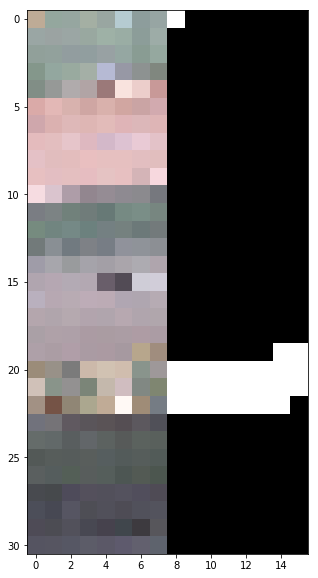

In [6]:
def data_generator(gmm_loader,
                   tile_size = cfg.TILE_SIZE,
                   epoch_size = cfg.TRAIN.EPOCH_SIZE):
    iter = 0
    for i in range(epoch_size):        
        yield gmm_loader.load_random()
        
for x,y in data_generator(train_loader,epoch_size=1):
    print x.shape
    draw_sample(x,y,8,cfg.SEQ_LENGTH//8)
    break

In [7]:
import theano
import theano.tensor as T

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


# Build model

In [8]:
from utils import get_network_str,save_weights,load_weights
import lasagne
from lasagne import layers as L
from lasagne.nonlinearities import rectify
from theano_utils import histogram_loss
from lasagne.regularization import regularize_network_params,l2
from gmm_op import get_gmm,calc_log_prob_gmm,calc_log_prob_gmm_componetwise
from theano_utils import split

data = T.tensor4(name='data')
label = T.tensor3(name='label')

def FCN(data,ndim=cfg.ndim,verbose=True,model_name=''):
    res = L.InputLayer((None,3,None,None)
                           ,data
                           ,name='data')
#     res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=6,
#                         nonlinearity=rectify,pad='same',
#                         name='conv1')
#     res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=12,
#                         nonlinearity=rectify,pad='same',
#                         name='conv2')
#     res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=ndim,
#                         nonlinearity=rectify,pad='same',
#                         name='conv3')
    if(model_name != ''):
        load_weights(res,model_name)
    print get_network_str(res,incomings=True,outgoings=True)
    sym = lasagne.layers.get_output(res)
    sym = T.transpose(sym,(0,2,3,1))
    sym = sym/(T.sqrt(T.square(sym).sum(-1)+1e-8)[:,:,:,None])
    params = lasagne.layers.get_all_params(res, trainable=True)
    l2_loss = 1e-4 * regularize_network_params(res, l2)
    return res,sym,params,l2_loss
               

def soft_predict_sym(features,means,covars,weights):
    return 1.-T.nnet.sigmoid(calc_log_prob_gmm(features,means,covars,weights))


# Train

In [21]:
def get_output(X,t_size=cfg.TILE_SIZE,o_size=cfg.OUT_SIZE):
    return X[:,:,(t_size[1]-o_size[1])//2:(t_size[1]+o_size[1])//2,\
              (t_size[0]-o_size[0])//2:(t_size[0]+o_size[0])//2]


def make_train_fn(model_name=''):
    def split_tr_p_n(x,y):
        x_tr_p,x_n = split(x,y)
        x_p = x_tr_p[-x_n.shape[0]:]
        x_tr = x_tr_p[:-x_n.shape[0]]
        return x_tr,x_p,x_n
    
    data = T.tensor4(name='data')
    label = T.tensor3(name='label')
    net,X,params,l2_loss = FCN(data,ndim=cfg.ndim,model_name=model_name)
    X = X[:,X.shape[1]//2:X.shape[1]//2+1,X.shape[2]//2:X.shape[2]//2+1,:]
    X = X.reshape((-1,X.shape[-1]))
    x_tr,x_p,x_n = split_tr_p_n(X,label.flatten())
    m,c,w = get_gmm(x_tr,cfg.gm_num,cfg.ndim)
    p_n = calc_log_prob_gmm(x_n,m,c,w)
    p_p = calc_log_prob_gmm(x_p,m,c,w)
    loss = histogram_loss(p_n,p_p,1e-4,100)[0]+l2_loss
    prediction = T.nnet.sigmoid(T.concatenate([p_p,p_n],axis=0))
    Y = T.concatenate([T.ones_like(p_p),T.zeros_like(p_n)],axis=0)
    G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))
    updates = lasagne.updates.adam(loss,params,G_lr)
    train_fn = theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True, updates=updates)
    print 'train_fn compiled'
    return train_fn,G_lr,net

train_fn,G_lr,net=make_train_fn()


In -->     Layer    --> Out    Description              
-------    -----    -------    -----------              
[]         0        []         data(None, 3, None, None)
train_fn compiled


In [22]:
G_lr.set_value(np.float32(0.001))

In [23]:
hard = []
cur = 0

In [25]:
from sklearn.metrics import average_precision_score

for j in range(0,1):
    train_loss=0
    train_acc=0
    for i,batch in enumerate(data_generator(train_loader,epoch_size=100)):
        res = train_fn(*batch)
        acc = average_precision_score(res[2],res[3])
        train_acc +=acc
        train_loss+=res[0]
#         if(res[1] < .8):
#             if( len(hard) < 1000):
#                 hard.append(batch)
#             else:
#                 hard[cur] = batch
#                 cur = (cur+1) % len(hard)
#         for k in range(min(3,len(hard))):
#             batch = hard[np.random.randint(0,len(hard))]
#             res = train_fn(*batch)
        print '\r epoch %i batch %i loss=%.2f ,acc=%.2f l=%.2f a=%.2f'%(j,i,train_loss/float(i+1),train_acc/float(i+1),res[0],acc),
    print ''
    save_weights(net,'models/%s%03d'%(cfg.NAME,j))
    if(j == 50):
        G_lr.set_value(np.float32(0.0001))
    print ''

 epoch 0 batch 99 loss=1147274.33 ,acc=0.92 l=168.60 a=1.00 .755                                                          
checkpoint models/no_params000.npz



# Evaluete model

In [47]:
from test_tools import iretate_test_dataset,make_features,make_gmms,fit_gmms,predict_pixelwise

def make_test(feature_fn,predict_fn,out_dir='results/'+cfg.NAME,dataset='dataset',max_frames=300,im_size = (320//2,240//2)):
    for folder,imgs,masks in iretate_test_dataset(out_dir,dataset,max_frames,im_size):        
        print folder,'generate_features,',
        data = make_features(feature_fn,imgs)
        gmms = make_gmms(imgs.shape[1:-1])
        print 'fit gmms,',
        fit_gmms(data[:100],gmms,masks[:100])
        print 'predict,',
        prediction = predict_pixelwise(data[100:],gmms,predict_fn)
        print 'save'
        imgs = imgs[100:]
        masks = masks[100:]      
        prediction = (prediction*255).astype(np.uint8)
        for i in range(len(imgs)):
            cv2.imwrite(folder+'/'+str(i)+'.png',prediction[i])
            cv2.imwrite(folder+'/'+str(i)+'_true.png',masks[i])
            cv2.imwrite(folder+'/'+str(i)+'_input.jpg',imgs[i])
    print 'test complit'

In [34]:
data=T.tensor4()
feature_sym = FCN(data,model_name='')[1]#models/%s%03d'%(cfg.NAME,0))[1]
feature_fn = theano.function([data],feature_sym,allow_input_downcast=True)


In -->     Layer    --> Out    Description              
-------    -----    -------    -----------              
[]         0        []         data(None, 3, None, None)


In [50]:
data,m,c,w=T.matrix(),T.matrix(),T.matrix(),T.vector()
predict_fn = theano.function([data,m,c,w],soft_predict_sym(data,m,c,w),allow_input_downcast=True)

In [51]:
make_test(feature_fn,predict_fn)

results/no_params/badWeather/blizzard generate_features, fit gmms, predict, save
results/no_params/baseline/highway generate_features, fit gmms, predict, save
results/no_params/cameraJitter/badminton generate_features, fit gmms, predict, save
results/no_params/dynamicBackground/boats generate_features, fit gmms, predict, save
results/no_params/shadow/backdoor generate_features, fit gmms, predict, save
results/no_params/thermal/corridor generate_features, fit gmms, predict, save
test complit


# Calc metric

In [66]:
from sklearn.metrics import average_precision_score

def calc_metrics_img(predict,label):
    mask = (label.flatten()>230)|(label.flatten() < 50)
    def prepare(x):
        res = np.zeros_like(x,dtype=np.float32)
        res/=255.
        return res[mask].flatten()
    p = (predict.astype(np.float32)/255.).flatten()[mask]
    y = (label.astype(np.float32)/255.).flatten()[mask]
    y[y>0.5] = 1.
    y[y<=0.5] = 0.
    return average_precision_score(y,p)

def calc_metrics_folder(data_dir):
    res = []
    for j in os.listdir(data_dir)[:10]:
        if(j.find('true')>=0 or j.find('input')>=0):
            continue
        pred = cv2.imread(data_dir+'/'+j)
        if(pred.mean() > 240):
            continue
        true = cv2.imread(data_dir+'/'+j[:-4]+'_true.png')
        res.append(calc_metrics_img(pred,true))
    if(len(res) == 0):
        return None
    return np.array(res).mean(0)

def calc_metric_all_folders(data_dir):
    res = []
    f = open('results/'+cfg.NAME+'.txt','w')
    for j in os.listdir(data_dir):
        folder = data_dir+'/'+j+'/'+os.listdir(data_dir+'/'+j)[0]
        metric = calc_metrics_folder(folder)
        if not (metric is None):
            res.append(metric)
            f.write(folder+' ' +str(res[-1])+'\n')
            print folder,res[-1]
    f.write(str(np.array(res).mean(0)))
    f.close()
    return np.array(res).mean(0)


calc_metric_all_folders('results/'+cfg.NAME)

results/no_params/badWeather/blizzard 0.502382895721
results/no_params/baseline/highway 0.828983140714
results/no_params/cameraJitter/badminton 0.909376886129
results/no_params/dynamicBackground/boats 0.915358261752
results/no_params/shadow/backdoor 0.83113477353
results/no_params/thermal/corridor 0.568385242147


0.75927019999885459

In [67]:
str(cfg)

"{'ndim': 3, 'NAME': 'no_params', 'LABELS': [0, 0, 0, 0, 1], 'SEQ_LENGTH': 250, 'IS_COLOR': True, 'LABEL_NUM': 2, 'TRAIN': {'EPOCH': 0, 'EPOCH_NUM': 1000, 'BATCH_SIZE': 2, 'EPOCH_SIZE': 100}, 'MOTION_RATE': 0.9, 'gm_num': 4, 'OUT_SIZE': [1, 1], 'TILE_SIZE': [16, 16], 'LABEL_VALUES': [0, 50, 85, 170, 255]}"